In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# NLP processing

In [ ]:
path = "/content/drive/MyDrive/EPFL/AppliedDataScience/Project/ada-2022-project-adlucere2022/"
import pandas as pd
import numpy as np
import regex, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Load the plot summaries dataset

In [ ]:
plots = pd.read_csv(path + './data/movie_data_imdbscores.csv')
plots.dropna(inplace = True, subset = ['plot_summary'])
plots.shape

(31291, 44)

Text preprocessing pipeline. Stopword filtering, non alphanumerical string filtering, duplicate filtering and lemmatization.

In [ ]:
def text_preprocessing_pipeline(x, reg, stopwords, lemmatizer):
    return " ".join([lemmatizer(w) for w in # lematize
            word_tokenize(reg.sub('', x).lower().strip()) #tokenized words + regex pattern
            if w not in stopwords and w.isalpha()]) # that are not stopwords or numbers

In [ ]:
reg = regex.compile('[%s]' % regex.escape(string.punctuation))
stopw = list(stopwords.words('english'))
lemmatizer = WordNetLemmatizer().lemmatize

Apply the pipeline

In [ ]:
plots.plot_summary = plots.plot_summary.apply(
    text_preprocessing_pipeline,
    reg = reg, stopwords = stopw, lemmatizer = lemmatizer)

In [ ]:
plots.to_csv(path + './data/plot_summaries_preprocessed.csv', index = False)

# TF-iDF analysis


Load the data

In [15]:
path = "/content/drive/MyDrive/EPFL/AppliedDataScience/Project/ada-2022-project-adlucere2022/"

# Basic Stuff
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import json
import matplotlib as mpl
import seaborn as sns 
from itertools import combinations

# Feature engineering and clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import FactorAnalysis
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Stats
from scipy import stats

# Word Cloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

Customize Matplotlibs parameters

In [16]:
def set_mpl_params(COLOR = 'black'):  
  mpl.rcParams['text.color'] = COLOR
  mpl.rcParams['font.weight'] = 'normal'
  mpl.rcParams['figure.titleweight'] = 'normal'
  mpl.rcParams['axes.labelcolor'] = COLOR
  mpl.rcParams['axes.edgecolor'] = COLOR
  mpl.rcParams['xtick.color'] = COLOR
  mpl.rcParams['ytick.color'] = COLOR
  mpl.rcParams['figure.facecolor'] = (1,1,1,0)
  mpl.rcParams['savefig.facecolor'] = (0,0,0,0)
  mpl.rcParams['savefig.transparent'] = False

Select variables to keep in analysis

In [17]:
to_keep = ['movie_id', 'release_date', 
           #'runtime', 'actor_age_at_movie_release',
       'english language','german language', 'silent film language', 'spanish language',
       'japanese language', 'italian language', 'tamil language',
       'hindi language', 'malayalam language', 'mandarin language',
       'french language', 'Action', 'Adventure', 'Horror', 'Thriller', 'Drama',
       'Crime Fiction', 'Black-and-white', 'Comedy', 'Indie', 'Short Film',
       'Silent film', 'Family Film', 'World cinema', 'Musical',
       'Action/Adventure', 'Romance Film', 'Romantic drama', 'Comedy film',
       'Documentary', 'F_gender_porportion', 'averageRating',
       'numVotes', 'plot_summary']
plots = pd.read_csv(path + './data/plot_summaries_preprocessed.csv')[to_keep].set_index('movie_id')
plots.release_date = pd.to_datetime(plots.release_date).apply(lambda x: x.year)

plots.dropna(inplace = True)
plots.shape

(31291, 35)

## TF-iDF matrix computation

Compute the TF-iDF matrix

In [18]:
vectorizer = TfidfVectorizer(max_features = 1000)
vectorized = vectorizer.fit_transform(plots.plot_summary)

In [19]:
vectorized = pd.DataFrame(vectorized.toarray(), columns = list(vectorizer.vocabulary_.keys()), index = plots.index)

## KMeans

Try $k$ clusters from 2 to 15 and compute the inertia and silhouette score

In [ ]:
score = {"inertia": [], "silhouette": []}
range_ = range(2, 15)
for k in tqdm(range_):
  kmeans = KMeans(k)

  kmeans.fit(vectorized)

  labels = kmeans.labels_

  score['inertia'].append(kmeans.inertia_)
  score['silhouette'].append(silhouette_score(vectorized, labels))

100%|██████████| 13/13 [18:04<00:00, 83.41s/it]


Save results, the past computation takes long to finish

In [ ]:
# with open(path + "./data/kmeans_metrics_tfidf.json" , "w") as f:
#   json.dump(score, f)

In [ ]:
with open(path + "./data/kmeans_metrics_tfidf.json" , "r") as f:
   score = json.load(f)

Plot the metrics computed before to find the best $k$ to choose

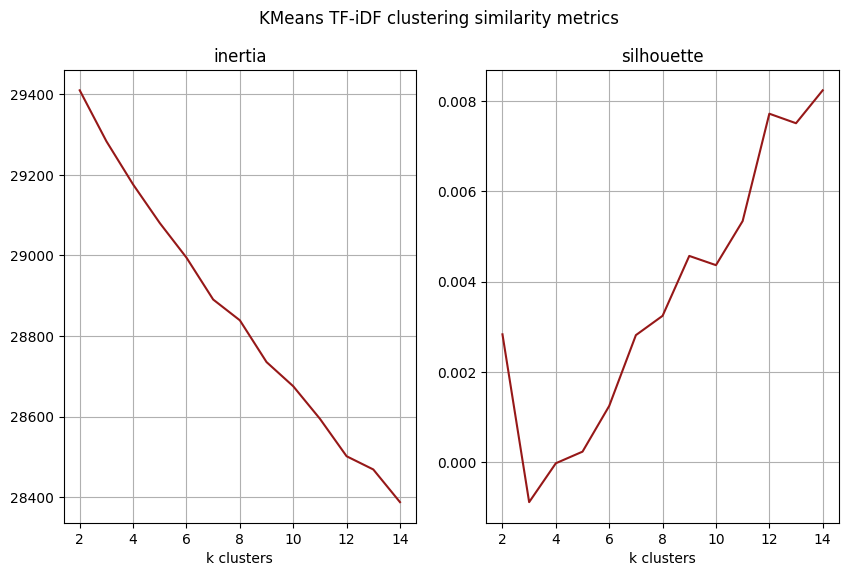

In [ ]:
# Set graphics params
set_mpl_params('black')
fig, ax = plt.subplots(1, 2, figsize = (10,6), dpi = 100, sharex = True)
ax = ax.flatten()
for i, m in enumerate(score):
  ax[i].plot(range_, score[m], color = (150/255, 24/255, 24/255, 1))
  ax[i].set(title = m, xlabel = 'k clusters')
  ax[i].grid()

fig.suptitle("KMeans TF-iDF clustering similarity metrics")
# plt.savefig(path + './figs/Kmeans.png')
fig.show()

Based on word distribution of plots, the movies have a tendency towards being clustered by a higher number of $k$ clusters tested.

## DBSCAN

Test values of min samples (min neighbours) and observe the number of clusters generated, silhouette score for non noise clusters and percentage of assigned noise.

In [ ]:
score_dbscan= {"n_clusters": [], "noise_propor": [], "silhouette": []}
range_ = range(2, 15)
for n in tqdm(range_):
  dbscan = DBSCAN(min_samples = n)

  dbscan.fit(vectorized)

  labels = dbscan.labels_

  # noise should not be considered for clustering metrics
  noise_mask = np.where(labels != -1, True, False)

  labels = labels[noise_mask]

  score_dbscan['n_clusters'].append(len(np.unique(labels)))

  if len(labels) > 1:
    score_dbscan['silhouette'].append(silhouette_score(vectorized.iloc[noise_mask ,:], labels))
  else:
    score_dbscan['silhouette'].append(-1) # lower bound for silhouette score, clusters cannot be distinguished because its all noise or there is only 1 cluster

  score_dbscan['noise_propor'].append(1 - len(labels) / vectorized.shape[0])


100%|██████████| 13/13 [12:54<00:00, 59.61s/it]


Save results to not redo computations

In [ ]:
# with open(path + "./data/dbscan_metrics_tfidf.json" , "w") as f:
#   json.dump(score_dbscan, f)

In [ ]:
with open(path + "./data/dbscan_metrics_tfidf.json" , "r") as f:
  score_dbscan = json.load(f)

Plot the results

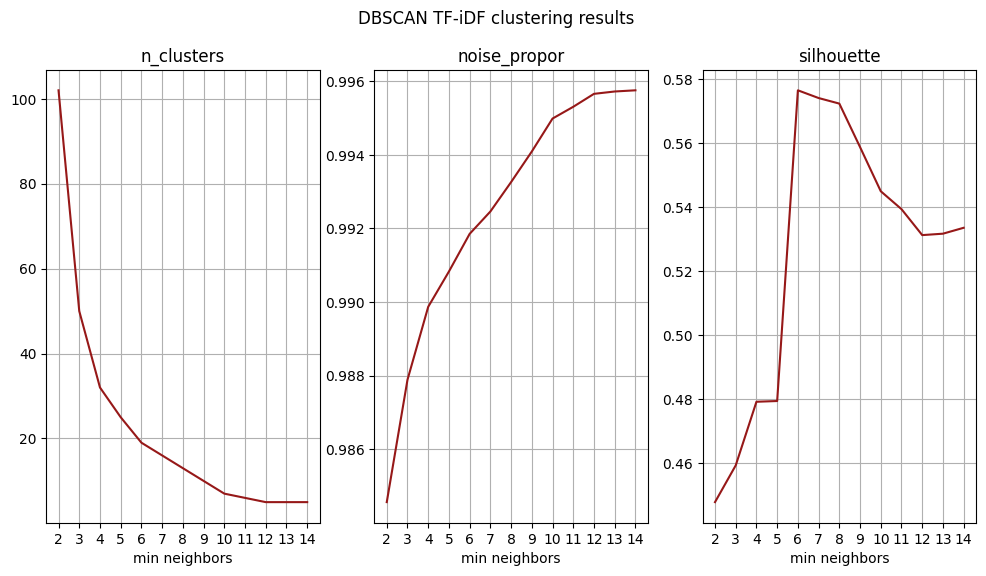

In [ ]:
# Set graphics params
set_mpl_params('black')
fig, ax = plt.subplots(1, 3, figsize = (12,6), dpi = 100, sharex = True)
ax = ax.flatten()

range_ = range(2, 15)
for i, m in enumerate(score_dbscan):
  ax[i].plot(range_, score_dbscan[m], color = (150/255, 24/255, 24/255, 1))
  ax[i].set(title = m, xlabel = 'min neighbors', xticks = range_)
  ax[i].grid()

fig.suptitle("DBSCAN TF-iDF clustering results")
# plt.savefig(path + './figs/DBSCAN.png')
fig.show()

Even though any min neighbour leads to clustering at least 98% of the data as noise. We set min neighbors to 6 and vary $\varepsilon$ to see if the result becomes admissible. 

In [ ]:
min_n = 6

score_dbscan= {"n_clusters": [], "noise_propor": [], "silhouette": []}
range_ = np.linspace(0.3, 0.5, 6)
for e in tqdm(range_):
  dbscan = DBSCAN(min_samples = min_n, eps = e)

  dbscan.fit(vectorized)

  labels = dbscan.labels_

  # noise should not be considered for clustering metrics
  noise_mask = np.where(labels != -1, True, False)

  labels = labels[noise_mask]

  score_dbscan['n_clusters'].append(len(np.unique(labels)))

  if len(labels) > 1:
    score_dbscan['silhouette'].append(silhouette_score(vectorized.iloc[noise_mask ,:], labels))
  else:
    score_dbscan['silhouette'].append(-1) # lower bound for silhouette score, clusters cannot be distinguished because its all noise or there is only 1 cluster

  score_dbscan['noise_propor'].append(1 - len(labels) / vectorized.shape[0])


100%|██████████| 6/6 [05:55<00:00, 59.18s/it]


Save the results again

In [ ]:
# with open(path + "./data/dbscan_e_metrics_tfidf.json" , "w") as f:
#   json.dump(score_dbscan, f)

In [ ]:
with open(path + "./data/dbscan_e_metrics_tfidf.json" , "r") as f:
  score_dbscan = json.load(f)

Plot the results of varying $\varepsilon$ given min neighbours = 6

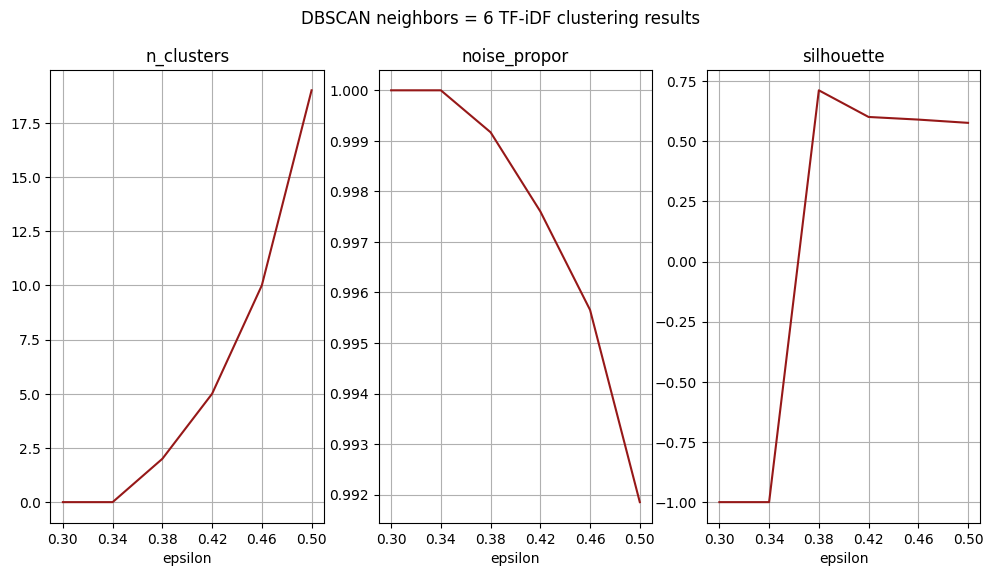

In [ ]:
# Set graphics params
set_mpl_params('black')
fig, ax = plt.subplots(1, 3, figsize = (12,6), dpi = 100, sharex = True)
ax = ax.flatten()

range_ = np.linspace(0.3, 0.5, 6)
for i, m in enumerate(score_dbscan):
  ax[i].plot(range_, score_dbscan[m], color = (150/255, 24/255, 24/255, 1))
  ax[i].set(title = m, xlabel = 'epsilon', xticks = range_)
  ax[i].grid()

fig.suptitle("DBSCAN neighbors = 6 TF-iDF clustering results")
# plt.savefig(path + './figs/DBSCAN_e.png')
fig.show()

We observe that to reduce the amount of noise we have to increase the radius of the neighborhood. But in turn that increases the amount of clusters. Hence, there may be an optimal combination of parameters that cluster good enough the word distribution without deeming almost all plots as noise. However, that may lead to an incraese of clusters that would make the analysis unadmissible, very hard to make (analyze +20 clusters at the same time). 

The hyperparameter testing may not be optimal, however due to computation limitations, performing grid search in a dense parameter space is way to computationally expensive for our data and algorithm.

## Factor Analysis

Factor analysis is made on the word frequency matrix. The aim of this analysis is to try and represent the matrix distribution as ``number of factors`` linear combinations of each of the word frequency over document. So, the loads represent its weight per factor. And taking a certain number of words equally per factor would yield the most representative words that explain the frequency distribution per factor.

We set the number of factors to be studied to 3 for ease of posterior analysis. 

In [20]:
fact = 3
fa = FactorAnalysis(fact)

fa.fit(vectorized)

FactorAnalysis(n_components=3)

In [21]:
# Extract factor loads of analysis, -> importance of each word per factor
factorWeights = pd.DataFrame(fa.components_.T, index = list(vectorizer.vocabulary_.keys()),
                                columns = [x+1 for x in range(0, fact)])
factorWeights.head()

,1,2,3
two,0.001191,0.000712,0.000024
college,0.003232,0.001274,-0.002107
guy,0.001471,-0.001574,-0.001766
get,0.002462,-0.002088,-0.001990
job,0.001287,-0.001940,0.000029


In [22]:
# Keep the number_of_words most important words per factor.
categories = {}

number_of_words = 100


for f in range(1,fact+1):
  temp = factorWeights[f].abs().sort_values(ascending = False)[:number_of_words]
  categories[str(f)] = set(temp.index)


factorAnalysisResults = pd.Series({key: ", ".join(categories[key]) for key in categories})

In [23]:
# Display most representative words per factor.
for x in range(len(factorAnalysisResults)):
    print(f"Factor {x+1}")
    print(factorAnalysisResults[x])

Factor 1
many, day, point, remains, arrive, mother, longer, rescue, happens, birthday, fall, joe, process, piece, hospital, walk, thinking, tom, work, wrong, earth, ghost, coming, shop, movie, german, despite, god, true, christmas, cliff, victor, army, informs, meet, contact, bobby, angeles, grab, causing, person, race, alien, found, investigation, insists, walking, sexual, inside, los, result, killer, used, form, system, fighting, bos, protect, project, lover, opportunity, steve, happy, shes, ask, keep, see, thought, flashback, running, he, manages, control, ultimately, saying, personal, series, released, enough, rich, robbery, helicopter, video, war, yet, bond, dying, spot, leg, prisoner, public, bed, jake, kidnapped, learn, boyfriend, voice, problem, parent, river
Factor 2
remains, trouble, message, mother, information, max, wood, rescue, french, prostitute, back, singer, destroyed, fall, become, gun, operation, process, last, hospital, jail, thinking, tom, door, light, situation, c

Now lets see the unique words per factor

In [24]:
# Display the most representative unique words per factor

for f in categories:

  rest = list(categories.keys())
  rest.remove(f)

  union = set()

  for f_ in rest:
    union = union.union(categories[f_])

  difference = sorted(list(categories[f].difference(union)))

  print(f"Unique words for factor{f} \n{', '.join(difference)}")

Unique words for factor1 
alien, angeles, army, arrive, bed, birthday, bobby, bond, cliff, day, despite, earth, fighting, form, found, ghost, helicopter, inside, keep, killer, learn, leg, longer, los, many, meet, movie, opportunity, parent, person, personal, piece, prisoner, protect, public, race, released, robbery, running, saying, see, series, shop, system, thought, victor, video, voice, walk, walking, war, work, wrong
Unique words for factor2 
alice, allow, along, asked, become, behind, called, character, convinces, cross, dead, different, exchange, feel, flees, flying, french, gun, information, jail, jenny, last, light, local, loses, max, message, night, north, owner, prostitute, raise, returned, school, singer, son, special, throw, tree, various, want, wood
Unique words for factor3 
another, around, arthur, better, bridge, bug, buy, career, close, completely, court, cousin, cry, danny, david, decides, destroy, fellow, finish, island, james, jimmy, join, julie, land, looking, minut

Now lets see the intersection between the assigned words to each factor

In [25]:
# Display shared words across all factors

intersec = set(categories["1"])
rest = list(categories.keys())
rest.remove("1")             
              
for f in rest:
  intersec = intersec.intersection(categories[f])

print(f"Shared words across all factors:\n{', '.join(intersec)}")

Shared words across all factors:
problem, tom, thinking, used, insists, informs, process, he, manages, causing, sexual, ask, dying, fall


Now we do the actual movie separation and assign factors to each movie based on the amount of words that its plot match with each factor.

In [26]:
# Per plot summary assign the most representative factor (word summary plot hits on factor most representative words)
def get_factor(plot):
    occurrences = dict(zip(factorAnalysisResults.index, [0]*len(factorAnalysisResults.index)))
    for word in plot.split():
        for x in occurrences:
            if word in factorAnalysisResults[x]:
                occurrences[x]+=1

    return max(occurrences, key = occurrences.get)

Why match on the ``number_of words`` per factor and not in the unique words per factor (in other words not use only occurences of unique words)? If we did the matching only in uniques we may lose interactions between the shared words. Shared words do not necessarily mean redundant information, we have no evidence to assume this redundancy, so we keep them.

In [27]:
plots["factor"] = plots.plot_summary.apply(get_factor).astype(int) # Computationally expensive

Lets examine the proportions of movies assigned to these factors

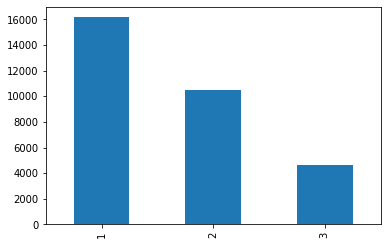

In [46]:
# Sets graphics params
set_mpl_params()
plots.factor.value_counts().plot.bar()
plt.show()

In [47]:
grouped = plots.groupby('factor')

Visualize the most representative words per factor in wordcloud

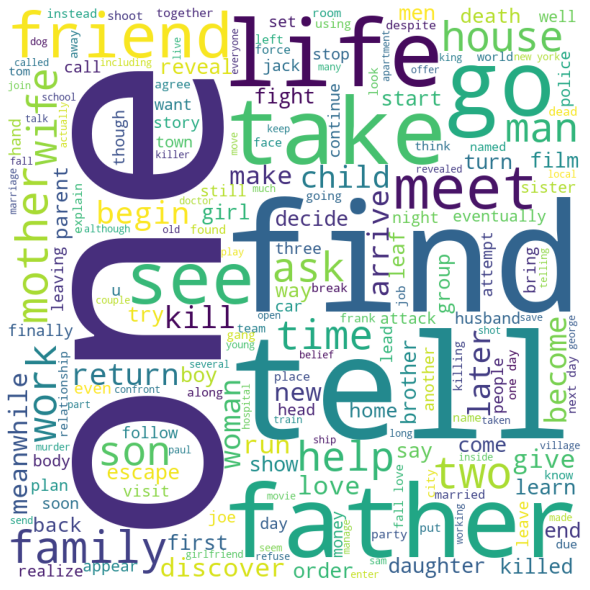

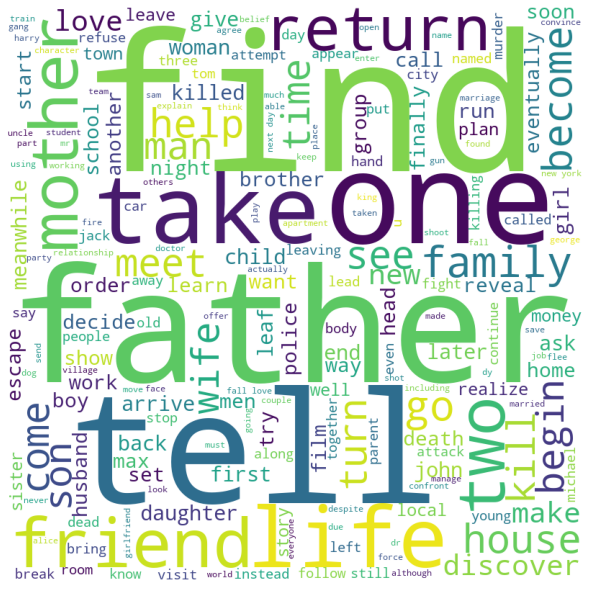

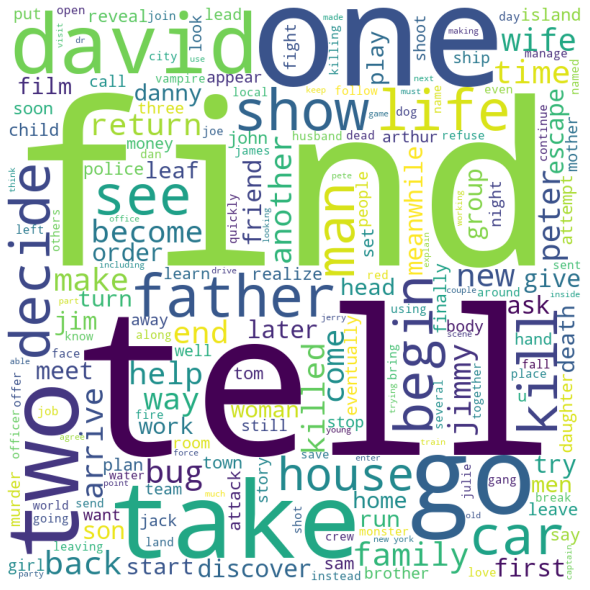

In [48]:
# For colors: https://amueller.github.io/word_cloud/auto_examples/colored.html

set_mpl_params()

stop_words = set(STOPWORDS)

for f, df in grouped:

  words = "".join(df.plot_summary.values)

  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stop_words, 
                  min_font_size = 10).generate(words)


  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.savefig(path + f"./figs/word_cloud_factor{f}.png")            

  print()  

``Important words`` do not appear to be the most frequent in the separated groups

We drop the plot summary as we won't use it anymore for the further analysis.

In [49]:
grouped = plots.drop('plot_summary', axis = 1).groupby('factor')

Now lets test for difference in means (for categoric variables mean proportion)

In [50]:
grouped.mean()

,release_date,english language,german language,silent film language,spanish language,japanese language,italian language,tamil language,hindi language,malayalam language,...,Romance Film,Romantic drama,Comedy film,Documentary,F_gender_porportion,averageRating,numVotes,factor_1,factor_2,factor_3
factor,,,,,,,,,,,,,,,,,,,,,
1,1985.108354,0.641399,0.027290,0.012500,0.037252,0.031993,0.028032,0.024381,0.058973,0.016646,...,0.188800,0.080879,0.029394,0.009530,0.338705,6.211955,14874.073824,1.0,0.0,0.0
2,1983.894551,0.645793,0.021797,0.014627,0.036616,0.026673,0.026673,0.023518,0.062237,0.019407,...,0.178967,0.074283,0.030019,0.008222,0.347114,6.267925,16838.211472,0.0,1.0,0.0
3,1979.925926,0.755299,0.026119,0.016699,0.025262,0.024834,0.022479,0.011347,0.029330,0.016057,...,0.122458,0.040677,0.033183,0.014344,0.299823,6.248448,16840.165061,0.0,0.0,1.0


In [51]:
# test features over dataframe with significance sidak correction
def test_over_variables(n_tests, vars, alpha, t1, t2):

    # Success flag:
    # At least one significant outcome -> underlying effect
    success = False
    
    #List to append significant results
    successes = []
    
    # Save pvalues
    pvalues = []

    print("_____________________________")
    print(f"{n_tests} t-tests with significance: {alpha:0.5f}")

    for var in vars:
        # Test var in both periods of time
        test_result = stats.ttest_ind(t1[var], t2[var])
        
        # If the result is significant...
        if test_result.pvalue < alpha:
            # Flag success true and keep result for future display
            success = True
            successes.append((var, test_result.pvalue))
        
        #print(f't-Test for Var: {var} -> p: {test_result[1]}')
        pvalues.append(test_result.pvalue)
    print("_____________________________")


    # Display significant results
    if success:
        print("Manifestation of underlying effect between groups in vars:")
        for var in successes:
            print(f"{var[0]} -> pvalue: {var[1]}")

    print(f"{len(successes)} / {len(vars)} significative results")
    
    return pvalues

def tester(grouped, grouped_on, alpha, correction = 'sidak', subtype = "by_group"):

  df_list = []

  total_tests = sum([len(df.columns.drop(grouped_on)) for (_, df) in grouped])

  # Iterate on all comparison combinations
  for (label_1,df_1), (label_2, df_2) in combinations(grouped, 2):
      
      # Drop the separating feature
      vars = df_1.columns.drop(grouped_on)
      
      print(">>>>>>>>>>>>>>>>>>>>>>>>>>")
          
      print(f"{label_1} vs {label_2}")

      # Test over all variables with 0.05 significance
      # Make p test adjustment based on number of experiments

      n_tests = len(vars)

      if subtype == 'by_group': # independece by group comparison
        k = n_tests
      else: # independence by all comparisons of groups
        k = total_tests


      if correction == 'sidak':
        # Sidak correction with k = n_tests
        alpha_c = 1 - (1 - alpha)**(1/k)
      else:
        # Bonferroni correction
        alpha_c = alpha / k

      

      pvalues = test_over_variables(n_tests, vars, alpha_c, df_1, df_2)
      
      
      # Save results
      df_list.append(pd.DataFrame([pvalues], index = [f"{label_1}_vs_{label_2}"], columns = vars))
      

  # Append al results
  comparison_df = pd.concat(df_list, axis = 0)

  return comparison_df

In [52]:
print("MEAN PROPORTION OF LANGUAGES GENRES ETC TEST")

test_results = tester(grouped, 'factor', 0.05, correction = 'sidak', subtype = 'by_experiment')

MEAN PROPORTION OF LANGUAGES GENRES ETC TEST
>>>>>>>>>>>>>>>>>>>>>>>>>>
1 vs 2
_____________________________
37 t-tests with significance: 0.00046
_____________________________
Manifestation of underlying effect between groups in vars:
release_date -> pvalue: 6.876824776735762e-05
Horror -> pvalue: 0.00042110514351877
Musical -> pvalue: 0.00025868725743105576
averageRating -> pvalue: 0.00013243388313750098
factor_1 -> pvalue: 0.0
factor_2 -> pvalue: 0.0
6 / 37 significative results
>>>>>>>>>>>>>>>>>>>>>>>>>>
1 vs 3
_____________________________
37 t-tests with significance: 0.00046
_____________________________
Manifestation of underlying effect between groups in vars:
release_date -> pvalue: 4.821437125735334e-37
english language -> pvalue: 3.559999703323431e-48
spanish language -> pvalue: 7.760959775571261e-05
tamil language -> pvalue: 6.083044293341679e-08
hindi language -> pvalue: 1.0674028035279903e-15
french language -> pvalue: 5.225473353836171e-05
Horror -> pvalue: 1.0429799569

The tabulation of tests across factors is ploted in the following heatmap

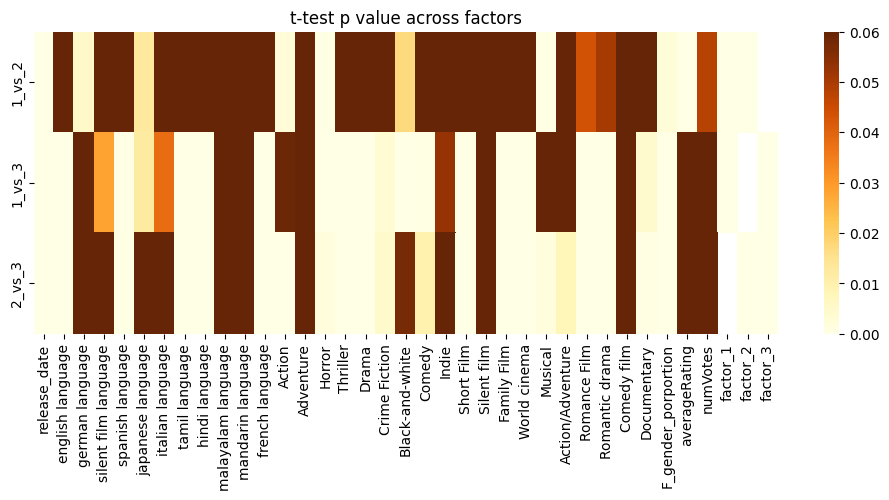

In [53]:
set_mpl_params()
plt.figure(figsize = (12, 4), dpi = 100)
sns.heatmap(test_results, cmap = "YlOrBr", vmin = 0, vmax = 0.06)
plt.title("t-test p value across factors")
plt.show()

Does this really work? Are factor-separated groups different to themselves (cohesive clustering interpretation)? Determine it by running the same tests random uniform separations between each factor separated group.

In [54]:
for f in range(1, plots.factor.max() + 1):
  print(f'\nFor factor: {f}\n')

  dat = plots[plots.factor == f].copy()

  dat['madeup_var'] = np.where(np.random.uniform(size = dat.shape[0])>= 0.5 , 'cat_1', 'cat_2')

  grouped_madeup = dat.drop(['plot_summary', 'factor'], axis = 1).groupby('madeup_var')
  _ = tester(grouped_madeup, 'madeup_var', 0.01, correction = 'bonferroni', subtype = 'by_group')


For factor: 1

>>>>>>>>>>>>>>>>>>>>>>>>>>
cat_1 vs cat_2
_____________________________
37 t-tests with significance: 0.00027
_____________________________
0 / 37 significative results

For factor: 2

>>>>>>>>>>>>>>>>>>>>>>>>>>
cat_1 vs cat_2
_____________________________
37 t-tests with significance: 0.00027
_____________________________
0 / 37 significative results

For factor: 3

>>>>>>>>>>>>>>>>>>>>>>>>>>
cat_1 vs cat_2
_____________________________
37 t-tests with significance: 0.00027
_____________________________
0 / 37 significative results


Every test concludes that the means are not statistically different, and hence, the separation is meaningful.

In [55]:
def bootstrap(data,num_iterations,confidence):
    
    sample_distribution = np.zeros(shape = (num_iterations,len(data.columns)))
    for i in range(num_iterations):
      sample_distribution[i, :] = data.sample(len(data), replace=True).mean(axis = 0)

    return  sample_distribution.mean(axis = 0),[np.percentile(sample_distribution, 100 *  (1-confidence)/2, axis = 0), np.percentile(sample_distribution, 100 * ((1+confidence)/2), axis = 0)]

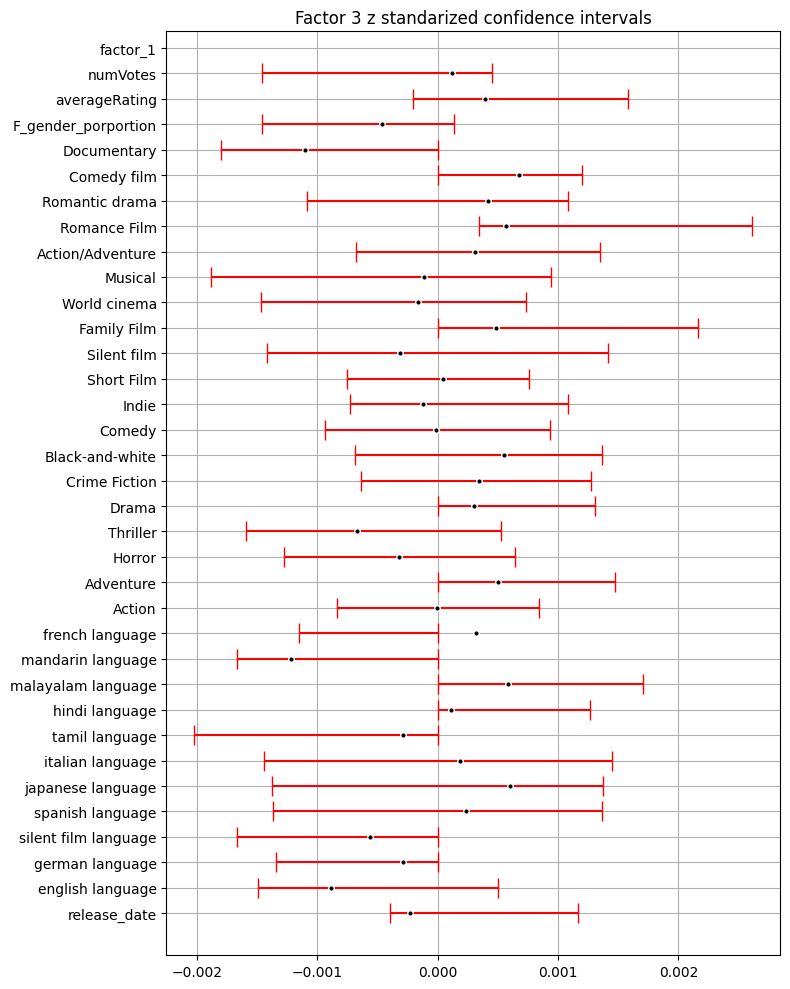

In [56]:
set_mpl_params()

# Code assumes each group has the same features

numerics = ['release_date', 'averageRating', 'numVotes']

CIS = {}

for f, df in grouped:

  print("\n\n")

  df = df.drop(['factor'], axis = 1)
  df = (df - df.mean(axis = 0)) / (df.std(axis = 0))

  ci =  bootstrap(df, 1000, 0.05)

  CI = pd.DataFrame([ci[0],ci[1][0], ci[1][1]], index = ['mean', 'lower', 'upper'], columns = df.columns)

  CI.loc["lower_err"] = CI.loc['mean'] - CI.loc['lower']
  CI.loc["upper_err"] = CI.loc['upper'] - CI.loc['mean']


  CIS[f"factor_{f}"] = CI.copy()

plt.figure(figsize = (8,10), dpi = 100)

plt.errorbar(CI.loc['mean'], CI.columns,  
            xerr = CI.loc[["lower_err", "upper_err"]].values,
            fmt = 'ro', markersize = 4, capsize = 7, markerfacecolor = 'k', markeredgecolor = 'white')

plt.title(f"Factor {f} z standarized confidence intervals")
plt.tight_layout()
plt.grid()
# plt.savefig(path + f"./figs/z_norm_CI_factor{f}.png")            
plt.show()

We now know that each group is different in at least a certain number of features to each other group. What would happen if we repeated the analysis comparing 1 group vs all the rest at the same time?

In [57]:
one_vs_all_tests = pd.DataFrame()

for f, _ in grouped:

  print(f"\nFactor {f} vs the rest")

  current = f'is_factor_{f}'

  plots[current] = plots.factor == f

  new_grouped = plots.drop(['plot_summary', 'factor'], axis = 1).groupby(current)


  tests_f_temp = tester(new_grouped, current, 0.01, correction = 'sidak', subtype = 'by_experiment')  

  tests_f_temp.index = [f'{f} vs all']

  plots = plots.drop(current, axis = 1)


  one_vs_all_tests = pd.concat([one_vs_all_tests, tests_f_temp], axis = 0)


Factor 1 vs the rest
>>>>>>>>>>>>>>>>>>>>>>>>>>
False vs True
_____________________________
37 t-tests with significance: 0.00014
_____________________________
Manifestation of underlying effect between groups in vars:
release_date -> pvalue: 1.5903741825129103e-18
english language -> pvalue: 1.0010324194814878e-12
Horror -> pvalue: 6.578338186685728e-08
Drama -> pvalue: 1.3041947727007857e-12
Short Film -> pvalue: 1.1732364137583199e-05
Family Film -> pvalue: 9.331285703200117e-05
World cinema -> pvalue: 9.769165774519497e-09
Romance Film -> pvalue: 2.312837055512176e-10
Romantic drama -> pvalue: 7.470104479058247e-09
factor_1 -> pvalue: 0.0
factor_2 -> pvalue: 0.0
factor_3 -> pvalue: 0.0
12 / 37 significative results

Factor 2 vs the rest
>>>>>>>>>>>>>>>>>>>>>>>>>>
False vs True
_____________________________
37 t-tests with significance: 0.00014
_____________________________
Manifestation of underlying effect between groups in vars:
Short Film -> pvalue: 8.395056413107753e-08
Musica

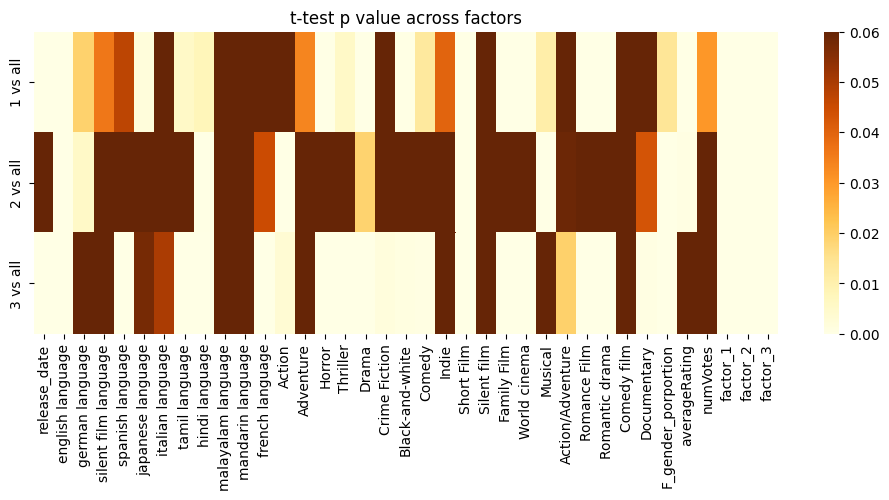

In [58]:
set_mpl_params()
plt.figure(figsize = (12, 4), dpi = 100)
sns.heatmap(one_vs_all_tests, cmap = "YlOrBr", vmin = 0, vmax = 0.06)
plt.title("t-test p value across factors")
plt.show()

We observe each of the group has its own distinguishable characteristics, such as factor 3 being the most different in terms of gender proportion. Which can be compared by retrieving again the proportion and means table. Factor 3 has the lowest mean proportion of female gender appereance with 0.299, a difference which is proved to be statistically significative.

In [ ]:
grouped.mean()

,release_date,english language,german language,silent film language,spanish language,japanese language,italian language,tamil language,hindi language,malayalam language,...,World cinema,Musical,Action/Adventure,Romance Film,Romantic drama,Comedy film,Documentary,F_gender_porportion,averageRating,numVotes
factor,,,,,,,,,,,,,,,,,,,,,
1,1985.108354,0.641399,0.027290,0.012500,0.037252,0.031993,0.028032,0.024381,0.058973,0.016646,...,0.150990,0.057240,0.104022,0.188800,0.080879,0.029394,0.009530,0.338705,6.211955,14874.073824
2,1983.894551,0.645793,0.021797,0.014627,0.036616,0.026673,0.026673,0.023518,0.062237,0.019407,...,0.143786,0.068260,0.099235,0.178967,0.074283,0.030019,0.008222,0.347114,6.267925,16838.211472
3,1979.925926,0.755299,0.026119,0.016699,0.025262,0.024834,0.022479,0.011347,0.029330,0.016057,...,0.094198,0.054806,0.113466,0.122458,0.040677,0.033183,0.014344,0.299823,6.248448,16840.165061


Save the factor assignment for further use

In [42]:
factor_lists =[]
for f in range(1, fact + 1):
  key = f"factor_{f}"
  plots[key] = plots.factor.apply(lambda x: x == f).astype(int)

  factor_lists.append(key)

In [44]:
plots.reset_index()[['movie_id'] + factor_lists].to_csv(path + './data/factor_assignment.csv', index = False)

<h2> Now:</h2> 

match words with factors to make categories.